In [5]:
# ===============================================================
# 1. Import Libraries
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam

# ===============================================================
# 2. Load Dataset
# ===============================================================
df = pd.read_csv("dataset/customer_shopping_data.csv")
print("Dataset loaded successfully")
print(df.shape)
df.head()

Dataset loaded successfully
(99457, 10)


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon



 Dataset Overview: 99457 rows × 10 columns
Columns: ['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity', 'price', 'payment_method', 'invoice_date', 'shopping_mall']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


,age,quantity,price
count,99457.000000,99457.000000,99457.000000
mean,43.427089,3.003429,689.256321
std,14.990054,1.413025,941.184567
min,18.000000,1.000000,5.230000
25%,30.000000,2.000000,45.450000
50%,43.000000,3.000000,203.300000
75%,56.000000,4.000000,1200.320000
max,69.000000,5.000000,5250.000000



❗ Missing Values per Column:
invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64


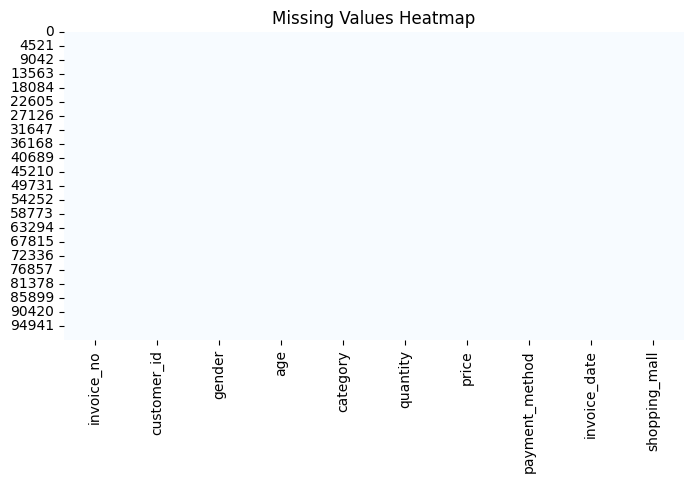

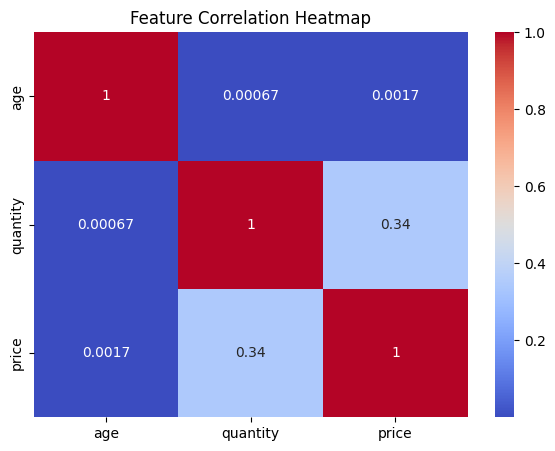

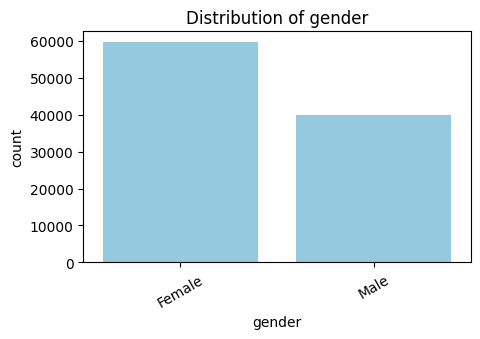

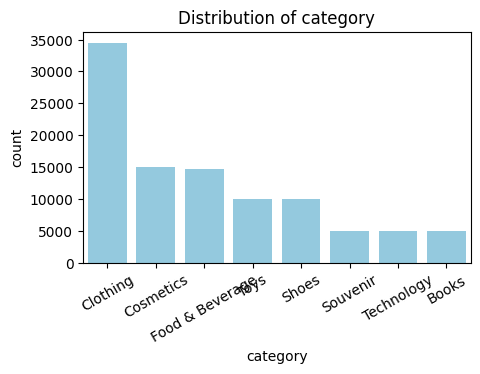

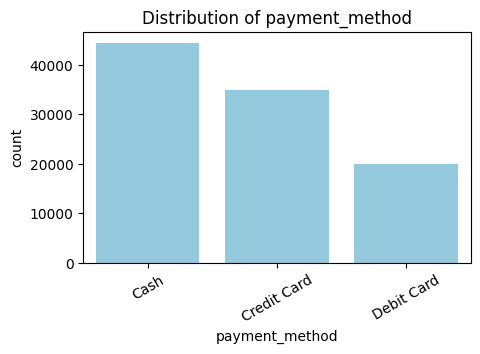

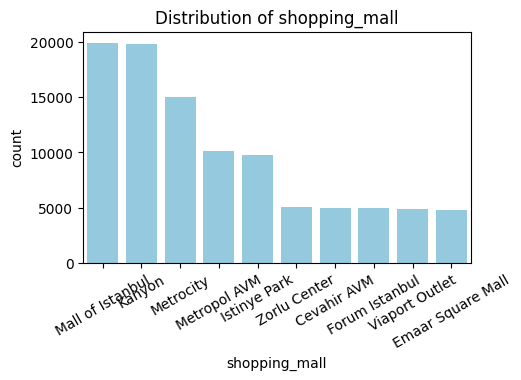

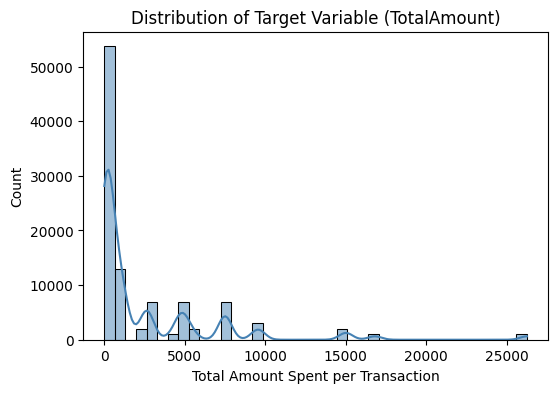

In [6]:
# ===============================================================
# 3. Exploratory Data Analysis (EDA)
# ===============================================================
import warnings
warnings.filterwarnings("ignore")  # Hide irrelevant warnings

# ---- Basic Overview ----
print(f"\n Dataset Overview: {df.shape[0]} rows × {df.shape[1]} columns")
print("Columns:", list(df.columns))
df.info()
display(df.describe())

# ---- Missing Values ----
print("\n❗ Missing Values per Column:")
print(df.isnull().sum())
plt.figure(figsize=(8,4))
sns.heatmap(df.isnull(), cbar=False, cmap="Blues")
plt.title("Missing Values Heatmap")
plt.show()

# ---- Correlation (Numeric) ----
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# ---- Category Distributions ----
for c in ["gender","category","payment_method","shopping_mall"]:
    plt.figure(figsize=(5,3))
    sns.countplot(x=df[c], order=df[c].value_counts().index, color="skyblue")
    plt.title(f"Distribution of {c}")
    plt.xticks(rotation=30)
    plt.show()

# ---- Target Distribution ----
df["TotalAmount"] = df["quantity"] * df["price"]
plt.figure(figsize=(6,4))
sns.histplot(df["TotalAmount"], kde=True, bins=40, color="steelblue")
plt.title("Distribution of Target Variable (TotalAmount)")
plt.xlabel("Total Amount Spent per Transaction")
plt.show()

In [7]:
# ===============================================================
# 4. Data Preprocessing
# ===============================================================

# Define target
df["TotalAmount"] = df["quantity"] * df["price"]
X = df.drop(columns=["invoice_no","customer_id","invoice_date","TotalAmount"])
y = df["TotalAmount"]

# Identify feature types
categorical = X.select_dtypes(include=["object"]).columns.tolist()
numeric = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical Features:", categorical)
print("Numerical Features:", numeric)

# ⚙️ Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f" Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Categorical Features: ['gender', 'category', 'payment_method', 'shopping_mall']
Numerical Features: ['age', 'quantity', 'price']
 Train shape: (79565, 7), Test shape: (19892, 7)


 Shared Train/Test created: (79565, 20), (19892, 20)
 Linear Regression → RMSE: 3038.21, MAE: 1726.93, R²: 0.496
Leak columns present in X?  False


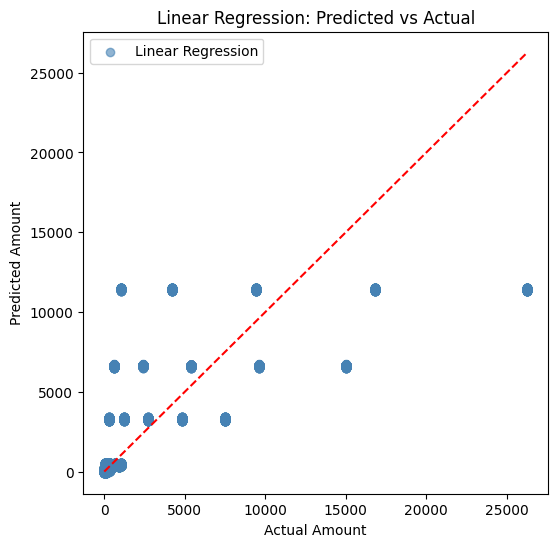

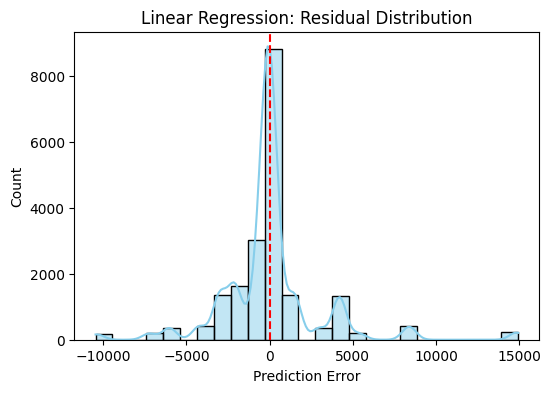

In [8]:
# ===============================================================
# 5. Model 1 – Linear Regression (leak-free, shared split)
# ===============================================================
# Target & Features
df["TotalAmount"] = df["quantity"] * df["price"]
y = df["TotalAmount"]

X = df.drop(columns=["invoice_no", "customer_id", "invoice_date",
                     "TotalAmount", "price", "quantity"])

# One-hot encode
X = pd.get_dummies(X, drop_first=True)

# Split first
X_train_common, X_test_common, y_train_common, y_test_common = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f" Shared Train/Test created: {X_train_common.shape}, {X_test_common.shape}")

# Scale on train only
scaler = StandardScaler(with_mean=False)  
X_train_scaled = scaler.fit_transform(X_train_common)
X_test_scaled  = scaler.transform(X_test_common)

#  Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_common)
y_pred_lr = lr_model.predict(X_test_scaled)

#  Evaluation
rmse_lr = np.sqrt(mean_squared_error(y_test_common, y_pred_lr))
mae_lr = mean_absolute_error(y_test_common, y_pred_lr)
r2_lr = r2_score(y_test_common, y_pred_lr)
print(f" Linear Regression → RMSE: {rmse_lr:.2f}, MAE: {mae_lr:.2f}, R²: {r2_lr:.3f}")

#  Quick sanity check
leak_cols = {"price", "quantity", "TotalAmount"}
print("Leak columns present in X? ", bool(leak_cols & set(pd.Index(X.columns))))

#  Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test_common, y_pred_lr, alpha=0.6, color="steelblue", label="Linear Regression")
plt.plot([y_test_common.min(), y_test_common.max()],
         [y_test_common.min(), y_test_common.max()], "r--")
plt.xlabel("Actual Amount"); plt.ylabel("Predicted Amount")
plt.title("Linear Regression: Predicted vs Actual")
plt.legend(); plt.show()

#  Residual Distribution
plt.figure(figsize=(6,4))
sns.histplot(y_test_common - y_pred_lr, bins=25, kde=True, color="skyblue")
plt.axvline(0, color="red", ls="--")
plt.title("Linear Regression: Residual Distribution")
plt.xlabel("Prediction Error"); plt.show()


🔧 Testing configuration: {'units1': 128, 'units2': 64, 'dropout': 0.2, 'lr': 0.001, 'batch': 32}
622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
 → R²: 0.4928, RMSE: 3047.82, MAE: 1725.43

🔧 Testing configuration: {'units1': 256, 'units2': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 32}
622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
 → R²: 0.4917, RMSE: 3051.36, MAE: 1736.87

🔧 Testing configuration: {'units1': 128, 'units2': 128, 'dropout': 0.2, 'lr': 0.0005, 'batch': 64}
622/622 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step
 → R²: 0.4928, RMSE: 3047.94, MAE: 1711.50

🔧 Testing configuration: {'units1': 64, 'units2': 32, 'dropout': 0.1, 'lr': 0.001, 'batch': 16}
622/622 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step
 → R²: 0.4927, RMSE: 3048.35, MAE: 1723.78

✅ Best configuration found:
{'units1': 128, 'units2': 64, 'dropout': 0.2, 'lr': 0.001, 'batch': 32} with R² = 0.493
622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step

🏁 Final DNN Regressor → RMSE: 3047.82, MAE: 1725.43, R²: 0.493
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 1s 535u

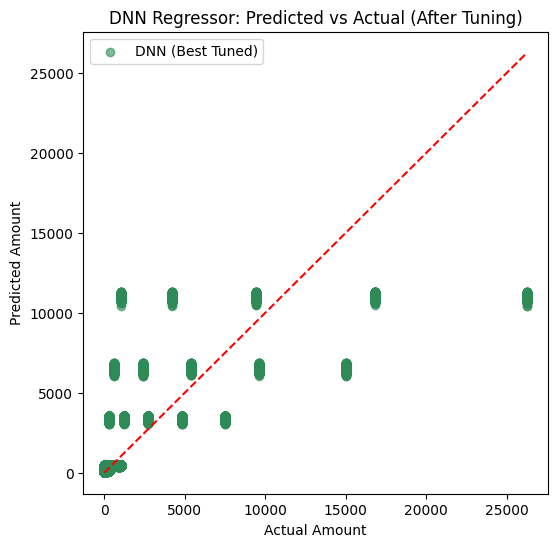

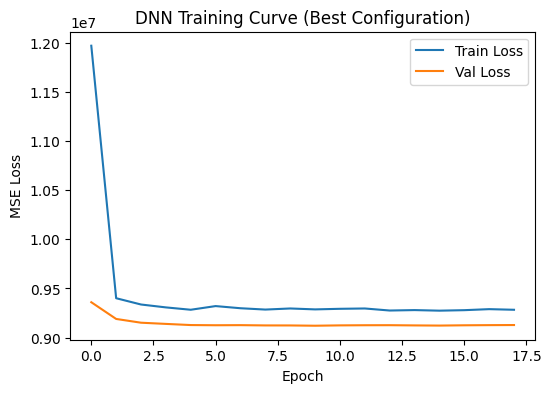

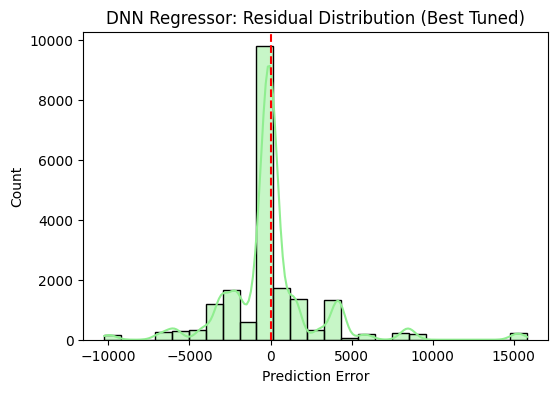

In [9]:
# ===============================================================
# 6. Model 2 – Deep Neural Network (DNN Regressor with Manual Tuning)
# ===============================================================

# Prepare data (already preprocessed)
X_train_np = np.asarray(X_train_scaled, dtype="float32")
X_test_np  = np.asarray(X_test_scaled, dtype="float32")
y_train_np = np.asarray(y_train_common, dtype="float32")
y_test_np  = np.asarray(y_test_common, dtype="float32")

tf.random.set_seed(42)
np.random.seed(42)

param_grid = [
    {'units1': 128, 'units2': 64,  'dropout': 0.2, 'lr': 0.001, 'batch': 32},
    {'units1': 256, 'units2': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 32},
    {'units1': 128, 'units2': 128, 'dropout': 0.2, 'lr': 0.0005, 'batch': 64},
    {'units1': 64,  'units2': 32,  'dropout': 0.1, 'lr': 0.001, 'batch': 16},
]

best_r2 = -999
best_params = None
best_model = None

for params in param_grid:
    print(f"\n🔧 Testing configuration: {params}")

    model = Sequential([
        Dense(params['units1'], activation='relu', input_shape=(X_train_np.shape[1],)),
        Dropout(params['dropout']),
        Dense(params['units2'], activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=params['lr']),
        loss='mse',
        metrics=['mae']
    )

    es = EarlyStopping(patience=8, restore_best_weights=True)
    history = model.fit(
        X_train_np, y_train_np,
        validation_split=0.2,
        epochs=60,
        batch_size=params['batch'],
        verbose=0,
        callbacks=[es]
    )

    y_pred = model.predict(X_test_np).flatten()
    r2 = r2_score(y_test_np, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    mae = mean_absolute_error(y_test_np, y_pred)
    print(f" → R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    if r2 > best_r2:
        best_r2 = r2
        best_params = params
        best_model = model
        best_history = history

print("\n✅ Best configuration found:")
print(best_params, "with R² =", round(best_r2, 3))

# ===============================================================
# Evaluate the Best Model
# ===============================================================
y_pred_dnn = best_model.predict(X_test_np).flatten()
rmse_dnn = np.sqrt(mean_squared_error(y_test_np, y_pred_dnn))
mae_dnn  = mean_absolute_error(y_test_np, y_pred_dnn)
r2_dnn   = r2_score(y_test_np, y_pred_dnn)
print(f"\n🏁 Final DNN Regressor → RMSE: {rmse_dnn:.2f}, MAE: {mae_dnn:.2f}, R²: {r2_dnn:.3f}")

# Check Train Performance
y_pred_train = best_model.predict(X_train_np).flatten()
rmse_train = np.sqrt(mean_squared_error(y_train_np, y_pred_train))
r2_train   = r2_score(y_train_np, y_pred_train)
print(f"Train Performance → RMSE: {rmse_train:.2f}, R²: {r2_train:.3f}")

# ===============================================================
# Visualization
# ===============================================================

#  Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test_np, y_pred_dnn, alpha=0.6, color="seagreen", label="DNN (Best Tuned)")
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel("Actual Amount")
plt.ylabel("Predicted Amount")
plt.title("DNN Regressor: Predicted vs Actual (After Tuning)")
plt.legend()
plt.show()

#  Loss Curve
plt.figure(figsize=(6,4))
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Val Loss')
plt.title("DNN Training Curve (Best Configuration)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

#  Residual Distribution
residuals_dnn = y_test_np - y_pred_dnn
plt.figure(figsize=(6,4))
sns.histplot(residuals_dnn, bins=25, kde=True, color="lightgreen")
plt.axvline(0, color="red", ls="--")
plt.title("DNN Regressor: Residual Distribution (Best Tuned)")
plt.xlabel("Prediction Error")
plt.show()

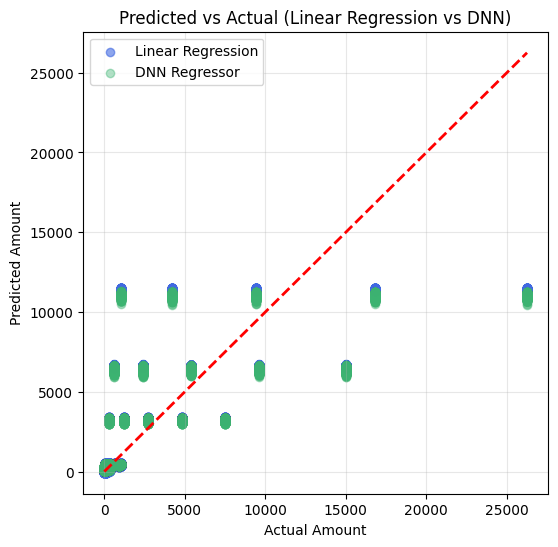

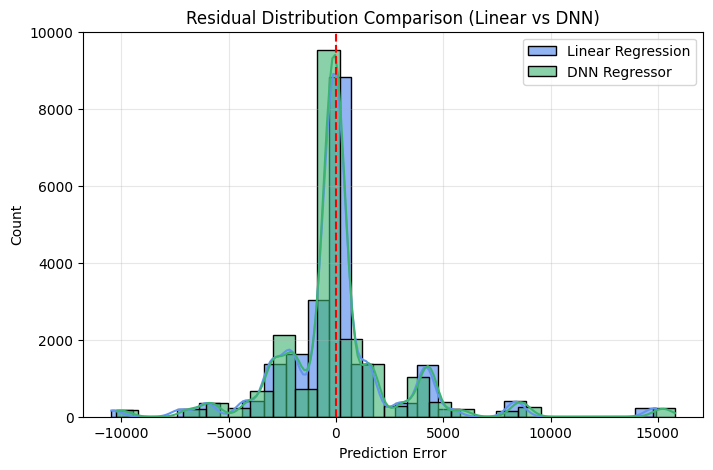

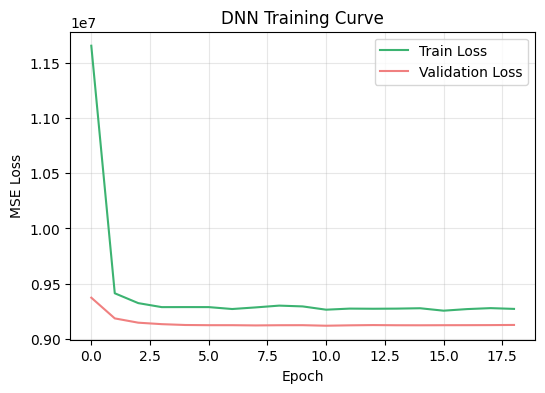


📊 Model Performance Comparison:


,Model,RMSE,MAE,R²
0,Linear Regression,3038.210,1726.931,0.496
1,DNN Regressor,3047.432,1709.796,0.493


In [23]:
# ===============================================================
# 7. Model Comparison (Linear Regression vs DNN)
# ===============================================================

# ---  Predicted vs Actual ---
plt.figure(figsize=(6,6))
plt.scatter(y_test_common, y_pred_lr, alpha=0.6, color="royalblue", label="Linear Regression")
plt.scatter(y_test_common, y_pred_dnn, alpha=0.4, color="mediumseagreen", label="DNN Regressor")
plt.plot([y_test_common.min(), y_test_common.max()],
         [y_test_common.min(), y_test_common.max()],
         'r--', lw=2)
plt.xlabel("Actual Amount")
plt.ylabel("Predicted Amount")
plt.title("Predicted vs Actual (Linear Regression vs DNN)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---  Residual Distribution ---
residuals_lr = y_test_common - y_pred_lr
residuals_dnn = y_test_common - y_pred_dnn

plt.figure(figsize=(8,5))
sns.histplot(residuals_lr, bins=25, kde=True, color="cornflowerblue", label="Linear Regression", alpha=0.7)
sns.histplot(residuals_dnn, bins=25, kde=True, color="mediumseagreen", label="DNN Regressor", alpha=0.6)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution Comparison (Linear vs DNN)")
plt.xlabel("Prediction Error")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---  Training Curve (DNN Only) ---
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss', color='mediumseagreen')
plt.plot(history.history['val_loss'], label='Validation Loss', color='lightcoral')
plt.title("DNN Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---  Performance Metrics Table ---
results_df = pd.DataFrame({
    "Model": ["Linear Regression", "DNN Regressor"],
    "RMSE": [rmse_lr, rmse_dnn],
    "MAE": [mae_lr, mae_dnn],
    "R²": [r2_lr, r2_dnn]
})

# Display neatly formatted table
print("\n📊 Model Performance Comparison:")
display(results_df.style.background_gradient(cmap="YlGnBu").format(precision=3))